In [1]:
import numpy as np
import pandas as pd
#import asyncio
#import aiohttp
import json
import csv
import requests
import time
from cryptodata import get_markets, get_pairs, get_ohlc
import os
import shutil
import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.max_rows',8)
def Timestamp_from_string(s='31 12 99'):
    #print(time.mktime(time.strptime(s, "%d %m %y")))
    return pd.Timestamp(time.mktime(time.strptime(s, "%d %m %y")), unit='s')

In [3]:
def get_daily_price(asset="btc", api="coinmetrics", data_type="price(usd)", start=0, end=time.time()):
    if (api == "coinmetrics"):
        try:
            url =  "https://coinmetrics.io/api/v1/get_asset_data_for_time_range/"+asset+"/"+data_type
            url = url + "/"+str(int(start)) +"/"+str(int(end))
            r = requests.get(url).json()['result']
            a = pd.DataFrame(r, columns = ['date(utc)',str(asset)+" "+str(data_type)])
            #print(url)
            a[a.columns[0]] = pd.to_datetime(a[a.columns[0]], unit = 's')

            return a
        except:
            print("Error: disfunctional API from Coinmetrics")            
            
    else:
        return 0


def get_assets_from_coimetrics():
    url = 'https://coinmetrics.io/api/v1/get_supported_assets'
    r  = requests.get(url).json()
    return r

def get_whole_market_from_coimetrics():
    assets = get_assets_from_coimetrics()
    market = {}
    print('Assets available:', assets)
    for asset in assets:
        #print('Getting data for',asset)
        market[asset] = get_daily_price(asset)
    return market

def merge_market_data(market, start=Timestamp_from_string('01 01 17')):
    '''merges the market data from the whole market, dumping coins which are too young '''
    assets = list(market.keys())
    #print(assets)
    #print(range(1,len(assets)))
    mkt = market[assets[0]]
    for i in range(1, len(assets)):
        if market[assets[i]]['date(utc)'][0] < start:
            mkt = pd.merge(mkt, market[assets[i]])
    
    return mkt


def get_coins_series(coins,start=Timestamp_from_string('01 01 17').timestamp()):
    returns = get_daily_price(coins[0], start=start)
    for i in range(1,len(coins)):
        returns = pd.merge(returns, get_daily_price(coins[i], start=start))
    return returns

 


def rate_of_return(df):
    cols = df.columns
    #print(cols)
    if (type(df[cols[0]][0]) == pd.Timestamp):
        a = df[cols[1:]].values
        b = a/a[0, :]
        df2 = pd.DataFrame(b, columns = df.columns[1:])
        #df2 = pd.merge(df2, pd.Dataframe(b, columns = cols[1:]))
        #print(b)
        
        return df2
    else:
        print('error return_from_values')

    

In [4]:
from cryptodata import *

In [254]:
import os
import shutil

class Pair:
    markets = {}
    data = {}
    def __init__(self, name, start=pd.Timestamp(0), end=pd.Timestamp(time.time(), unit='s'), period=24*60*60):
        self.name = str(name)
        self.period = period    
        self.start = start
        self.end = end
        self.markets = list_markets_containing_pair(self.name)
        self.metadata = pd.DataFrame([period, start, end])
        
    

def download_pair_data(pair, force_update = False):
    try:
        os.mkdir(pair.name)
    except:
        try:
            m = pd.read_csv('pair_metadata.csv')
        except:
#        if not (m == pair.metadata).all():
            shutil.rmtree(pair.name)
            os.mkdir(pair.name)
        #print('m\n',m)
        #print('pair.metadata', pair.metadata)
        #if not (m == pair.metadata).all():
        #    shutil.rmtree(pair.name)
        #    os.mkdir(pair.name)
    
    #print(pair.markets)
    for key in list(pair.markets):
        pair.data[key].to_csv(pair.name+'/'+key+'.csv')
    
    pair.metadata.to_csv('pair_metadata.csv')

def load_pair_data(name, start = 0, end = time.time(), period = 1440):
    mkt = os.listdir(name)
    for i in range(len(mkt)):
        mkt[i] = mkt[i][0:-4]
    return mkt

In [311]:
#b = list(a)
#c = list_markets_containing_pair()
def cryptowatch_summary(Pair):
    
    for exchange in list(Pair.markets):
        url = "https://api.cryptowat.ch/markets/"+exchange+"/"+Pair.name+"/summary"
        r = requests.get(url).json()
    return r

    
#r = cryptowatch_summary(btc)


def cryptowatch_volume_across_exchanges(ohlc_data, exchanges):
    data = ohlc_data[exchanges[0]][['CloseTime', 'Volume']]
    data = data.rename(index=str, columns={"CloseTime": "date(utc)", "Volume": exchanges[0]})
    for i in range(len(exchanges)):
        temp = ohlc_data[exchanges[i]][['CloseTime', 'Volume']]
        temp = temp.rename(index=str, columns={"CloseTime": "date(utc)", "Volume": exchanges[i]})
        #print(exchanges[i], temp.shape)
        data = pd.merge(data, temp)
    return data

def cryptowatch_closeprice_across_exchanges(ohlc_data, exchanges):
    data = ohlc_data[exchanges[0]][['CloseTime', 'ClosePrice']]
    #print(exchanges[0], data)
    data = data.rename(index=str, columns={"CloseTime": "date(utc)", "ClosePrice": exchanges[0]})
    for i in range(len(exchanges)):
        temp = ohlc_data[exchanges[i]][['CloseTime', 'ClosePrice']]
        temp = temp.rename(index=str, columns={"CloseTime": "date(utc)", "ClosePrice": exchanges[i]})
        data = pd.merge(data, temp)

        
        
    return data


def cryptowatch_ohlc(pair_name, exchange, period=24*60*60,
                     start=pd.Timestamp(2018,1,1),
                     end=pd.Timestamp(time.time(), unit='s')):
    
    url = "https://api.cryptowat.ch/markets/"+exchange+"/"+pair_name+"/ohlc"
    print(url)
    try:
        r = requests.get(url, params = {'before':int(end.timestamp()), 'after': int(start.timestamp()) }).json()
        return pd.DataFrame(r['result'][str(period)], columns =[ 'CloseTime', 'OpenPrice', 'HighPrice', 'LowPrice', 'ClosePrice', 'Volume','Other' ]
)
    except:
        print('API unavailable')
    #p = pd.DataFrame(r['result'][str(period)], columns = ['CloseTime', 'OpenPrice', 'HighPrice', 'LowPrice', 'ClosePrice', 'Volume' ])
    #p['date(utc)'] = pd.to_datetime(p['date(utc)'], unit='s')



In [131]:
a = get_markets()
btc = Pair('btcusdt')


In [241]:
btc.ohlc_data = cryptowatch_ohlc_data_for_pair(btc)

https://api.cryptowat.ch/markets/poloniex/btcusdt/ohlc


In [242]:
btc.ohlc_data['poloniex']

,CloseTime,OpenPrice,HighPrice,LowPrice,ClosePrice,Volume,Other
0,1490227200,1117.9800,1118.0000,986.220,1037.7000,11119.60400,0.0
1,1490313600,1034.8231,1057.0060,1002.520,1035.0000,5081.98050,0.0
2,1490400000,1035.0000,1037.5059,955.000,984.0000,7902.79250,0.0
3,1490400000,1035.0000,1037.5059,930.100,942.5100,13649.25300,0.0
...,...,...,...,...,...,...,...
495,1532908800,8218.0000,8298.0000,8125.623,8221.1510,449.38986,3697170.5
496,1532995200,8223.0100,8264.0000,7864.000,8178.0547,1090.66190,8811893.0
497,1533081600,8178.0547,8178.0547,7643.000,7731.5520,1668.38960,13054081.0
498,1533168000,7733.5537,7752.4020,7440.000,7616.0176,1419.31450,10731771.0


In [243]:
exchanges = sorted(list(btc.ohlc_data))
exchanges_list = ['poloniex', 'bittrex']
a = cryptowatch_volume_across_exchanges(btc.ohlc_data, exchanges_list   )
#btc.ohlc_data['wex']a = sorted(exchanges)

b = a[a.columns[1:]].values
#b.values/b.sum(axis =1)
c = b.sum(axis = 1)
d = np.reshape(np.repeat(c,b.shape[1]), b.shape)
b/d
weights = pd.DataFrame(b/d, columns = a.columns[1:])
#weights
btc.ohlc_data['bittrex']
#weights
btc.ohlc_data['poloniex']
a

KeyError: 'bittrex'

In [139]:
m = cryptowatch_closeprice_across_exchanges(btc.ohlc_data, exchanges)
n = m[m.columns[1:]].values
o = m[m.columns[1:]]*weights
p = o.values.sum(axis=1)
#p.dtype
index = pd.DataFrame({'date(utc)':m[m.columns[0]],'index':p})

#btc.ohlc_data[exchanges[0]]


poloniex       CloseTime  ClosePrice
0    1514764800  13769.3420
1    1514851200  13351.7390
2    1514937600  14738.0000
3    1515024000  15150.0000
..          ...         ...
210  1532908800   8221.1510
211  1532995200   8178.0547
212  1533081600   7731.5520
213  1533168000   7616.0176

[214 rows x 2 columns]


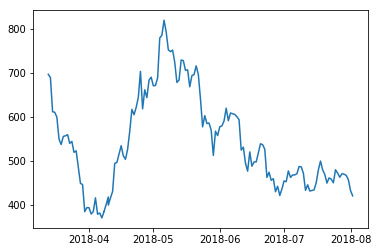

In [313]:
x = b['date(utc)']
y = b['index']

plt.plot(x,y)

locs, labels = plt.xticks()
#plt.show()


In [166]:
exchanges = sorted(list(btc.ohlc_data))
for ex in exchanges:
    print(btc.ohlc_data[ex].shape)
    
a = pd.Timestamp(2018,8,2)
b = pd.Timestamp(2018,1,1)
a-b
btc.start
pd.to_datetime(btc.end, unit='s')

(183, 7)
(214, 7)
(136, 7)
(35, 7)
(133, 7)
(214, 7)
(22, 7)


Timestamp('2018-08-02 20:09:50')

In [307]:
def pair_index(pair):
    pair.ohlc = cryptowatch_ohlc_data_for_pair(pair)
    exchanges = pair.markets

    ex_list = sorted(list(exchanges))[0:3]
    print('ex_list', ex_list)
    #print(exchanges)
    #print(pair.ohlc)
    a =  cryptowatch_volume_across_exchanges(pair.ohlc, ex_list)
    b = a[a.columns[1:]].values
    c = b.sum(axis = 1)
    d = np.reshape(np.repeat(c,b.shape[1]), b.shape)
    weights = pd.DataFrame(b/d, columns = a.columns[1:])
    
    m = cryptowatch_closeprice_across_exchanges(pair.ohlc, ex_list)
    n = m[m.columns[1:]].values
    o = m[m.columns[1:]]*weights
    p = o.values.sum(axis=1)
    
    index = pd.DataFrame({'date(utc)':m[m.columns[0]],'index':p})
    index['date(utc)'] = pd.to_datetime(index['date(utc)'], unit = 's')
    return index
def cryptowatch_ohlc_data_for_pair(Pair):
    exchanges = list(Pair.markets)
    
    data = {}
    #print(Pair.name)
    #print(exchanges)

    for ex in exchanges:
        data[ex] = cryptowatch_ohlc(Pair.name, ex, Pair.period, Pair.start, Pair.end)
        #print(data)
    return data


In [279]:
btc = Pair('btcusdt', period = 24*60*60)
#eth = Pair('ethusd',period = 24*60*60)
eth = Pair('ethusd')

In [308]:
pd.Timestamp(btc.start, unit='s')
pd.Timestamp(btc.end, unit='s')

a = pair_index(btc)
b = pair_index(eth)

https://api.cryptowat.ch/markets/poloniex/btcusdt/ohlc
https://api.cryptowat.ch/markets/okex/btcusdt/ohlc
https://api.cryptowat.ch/markets/binance/btcusdt/ohlc
https://api.cryptowat.ch/markets/hitbtc/btcusdt/ohlc
https://api.cryptowat.ch/markets/huobi/btcusdt/ohlc
https://api.cryptowat.ch/markets/bittrex/btcusdt/ohlc
https://api.cryptowat.ch/markets/wex/btcusdt/ohlc
ex_list ['binance', 'bittrex', 'hitbtc']
binance       CloseTime  ClosePrice
0    1517443200    10285.10
1    1517529600     9224.51
2    1517616000     8873.03
3    1517702400     9199.96
..          ...         ...
179  1532908800     8211.00
180  1532995200     8171.40
181  1533081600     7730.93
182  1533168000     7599.97

[183 rows x 2 columns]
https://api.cryptowat.ch/markets/quoine/ethusd/ohlc
https://api.cryptowat.ch/markets/cexio/ethusd/ohlc
https://api.cryptowat.ch/markets/bitfinex/ethusd/ohlc
https://api.cryptowat.ch/markets/kraken/ethusd/ohlc
https://api.cryptowat.ch/markets/bitbay/ethusd/ohlc
https://api.crypt

In [316]:
exchanges = sorted(list(btc.markets))

def reliable_exchanges(exchanges, start=pd.Timestamp(2018,1,1), end=pd.Timestamp(2018,8,1)):
    for ex in exchanges:
        
        

In [16]:
def list_markets_containing_pair(pair='btcusd'):
    try:
        r = requests.get("https://api.cryptowat.ch/markets").json()['result']
        exchanges = {item['exchange'] for item in r if (item['active'] is True and item['pair'] == pair)}
        return exchanges
    except:
        print('error')

def list_pairs(pairs=get_pairs(), p1='btc'):
    pairs = list(pairs)
    L = []
    for pair in pairs:
        if p1 == pair[:len(p1)]:
            L.append(pair)
    return L

def list_pairs_in_market(market):
    r = requests.get("https://api.cryptowat.ch/markets/"+market).json()['result']
    market_pairs = {item['pair'] for item in r if item['active'] is True}
    return market_pairs